In [6]:
import torch
import ST
from torchvision.models import resnet50
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import clear_output

In [7]:
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cpu')

# DETR

In [8]:
class DETR (torch.nn.Module):
    def __init__ (
        self,
        num_classes,
        hidden_dim,
        nheads,
        num_encoder_layers,
        num_decoder_layers,
    ):
        super().__init__()

        self.backbone = torch.nn.Sequential(*list(resnet50(pretrained=True).children())[:-2])
        self.conv = torch.nn.Conv2d(in_channels=2048,
                                    out_channels = hidden_dim,
                                    kernel_size = 1)
        self.transformer = torch.nn.Transformer(hidden_dim, nheads, num_encoder_layers, num_decoder_layers)
        self.linear_class = torch.nn.Linear(hidden_dim, num_classes + 1)
        self.linear_bbox = torch.nn.Linear(hidden_dim, 4)
        self.query_pos = torch.nn.Parameter(torch.rand(100,  hidden_dim))
        self.row_embed = torch.nn.Parameter(torch.rand(50, hidden_dim // 2))
        self.col_embed = torch.nn.Parameter(torch.rand(50, hidden_dim // 2))

    def forward(self, inputs):
        x = self.backbone(inputs)
        h = self.conv(x)
        H, W = h.shape[-2:]
        pos = torch.cat((
            self.col_embed[:W].unsqueeze(0).repeat(H, 1, 1),
            self.row_embed[:H].unsqueeze(1).repeat(1, W, 1)
        ), dim =-1).flatten(0, 1).unsqueeze(1)
        h = self.transformer(pos + h.flatten(2).permute(2, 0, 1),
                            self.query_pos.unsqueeze(1))
        return self.linear_class(h).squeeze(), self.linear_bbox(h).sigmoid().squeeze()

In [9]:
detr = DETR(num_classes=1,
            hidden_dim=256,
            nheads=8,
            num_encoder_layers=6,
            num_decoder_layers=6).to(device)

/home/vitalliy/.local/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/vitalliy/.local/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /home/vitalliy/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 97.8M/97.8M [01:33<00:00, 1.10MB/s]
/home/vitalliy/.local/lib/python3.12/site-packages

### Getting detection dataset

In [10]:
images = torch.load('Saved Tensors/Augmented images.pth')
bboxes = torch.load('Saved Tensors/bboxes.pth')
classes = torch.load('Saved Tensors/classes.pth')

In [11]:
train_images = images[:950].to(device)
val_images = images[950:].to(device)
train_bboxes = bboxes[:950].to(device)
val_bboxes = bboxes[950:].to(device)
train_classes = classes[:950].to(device)
val_classes = classes[950:].to(device)

# Training

In [18]:
num_of_epochs = 20000
batch_size = 2
learning_rate = 1e-4
scheduler_freq = 500
scheduler_gamma = 0.5

val_every = 10
show_every = 10
val_batch_size = 1
save_every = 100

bboxes_loss = torch.nn.MSELoss()
classes_loss = torch.nn.MSELoss()

optimizer = torch.optim.Adam(detr.parameters(), lr = learning_rate)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma = scheduler_gamma)

losses = {"train" : [], "val" : []}

In [13]:
def L1_Regularization(  # Add the result of this function to the loss calculating as follows:
            # loss = <...> + <regularizator name>.L1_Regularization()
            model,
            lamb=1e-4,
):
    l1_regularization = 0
    for param in model.parameters():
        l1_regularization += torch.norm(param, 1)
    return lamb * l1_regularization

### Training process

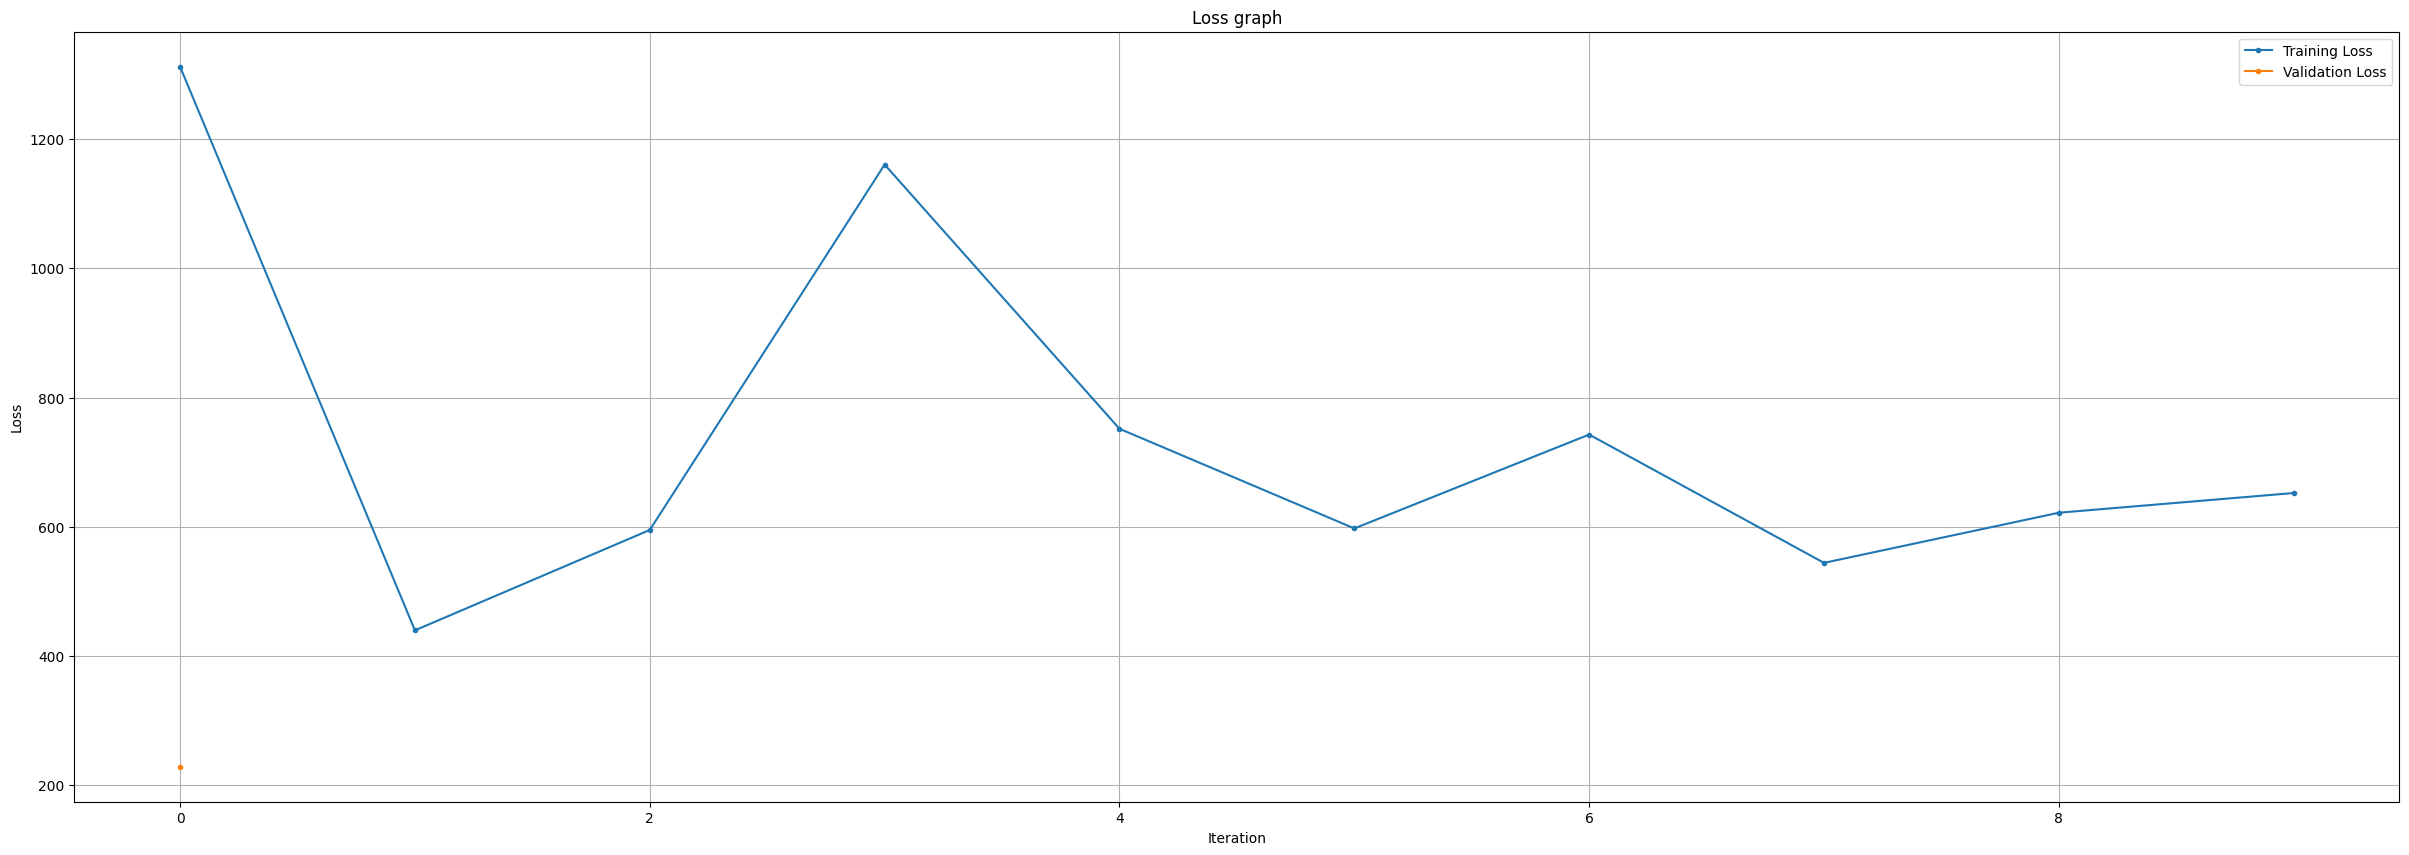

11 now
12 now
13 now


KeyboardInterrupt: 

In [19]:
detr.train()

for epoch in range(1, num_of_epochs + 1):
    print(f"{epoch} now")
    optimizer.zero_grad()
    batch = torch.randint(high = train_images.shape[0], size = [batch_size])

    general_loss = torch.zeros(1, device = device)
    
    for ind, current_batch in enumerate(batch):
        classes_pred, bboxes_pred = detr(train_images[current_batch].unsqueeze(0).to(device))
        loss_classes = classes_loss(classes_pred, train_classes[current_batch].to(device))
        loss_bboxes = bboxes_loss(bboxes_pred, train_bboxes[current_batch].to(device))
        loss = loss_classes + loss_bboxes
        general_loss += loss
    
    general_loss.backward()
    optimizer.step()

    losses["train"].append(general_loss.item())

    if epoch % val_every == 0:
        with torch.no_grad():
            val_batch = torch.randint(high = val_images.shape[0], size = [val_batch_size])
            
            val_classes_pred, val_bboxes_pred = detr(val_images[val_batch].to(device))
            val_loss_classes = classes_loss(val_classes_pred, val_classes[val_batch].to(device))
            val_loss_bboxes = bboxes_loss(val_bboxes_pred, val_bboxes[val_batch].to(device))
            
            val_gen_loss = val_loss_classes + val_loss_bboxes
        losses["val"].append(val_gen_loss.item())

    if epoch % show_every == 0:
        clear_output(True)
        fig, ax = plt.subplots(figsize=(30, 10))
        plt.title("Loss graph")
        plt.plot(losses["train"], ".-", label="Training Loss")
        plt.plot(torch.arange(0, epoch, show_every), losses["val"], ".-", label="Validation Loss")
        plt.xlabel("Iteration")
        plt.ylabel("Loss")
        plt.legend()
        plt.grid()
        plt.show()

    if epoch % scheduler_freq == 0:
        scheduler.step()

    if epoch % save_every == 0:
        torch.save(detr.state_dict())


## Using

In [10]:
def pred_perform (image):
    detr.eval()
    image = image.unsqueeze(0)
    logits, bboxes = detr(image)
    classes = torch.zeros(logits.shape[0])
    answer_bboxes = set()

    for ind, current_pred in enumerate(logits):
        classes[ind] = torch.argmax(current_pred)
        if classes[ind].round() == 1:
            xmin = (bboxes[ind][0] * 480).int().item()
            ymin = (bboxes[ind][1] * 270).int().item()
            xmax = (bboxes[ind][2] * 480).int().item()
            ymax = (bboxes[ind][3] * 270).int().item()
            answer_bboxes.add((xmin, ymin, xmax, ymax))

    ST.imshow(image.squeeze())

    detr.train()
    return classes, answer_bboxes

{(6, 3, 4, 2), (209, 197, 284, 215)}

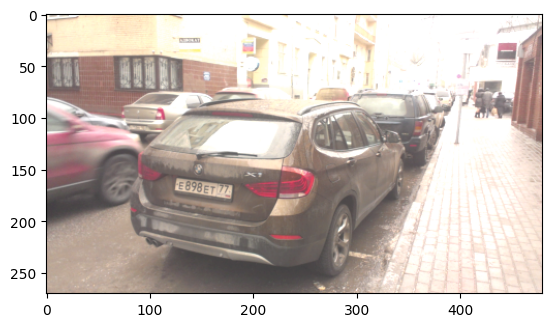

In [11]:
logits, boxes = pred_perform(train_images[30])
boxes